# One-Dimensional linear Aquifer Storage and Recovery.
## Exercise 1 Reduce numerical dispersion

In [1]:
# import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5, 3) # set default figure size
import flopy as fp  # import flopy and call it fp

Let's try to reduce numerical dispersion. There are three easy options to try to reduce numerical dispersion:
1. Use a more accurate solution approach for the advection part of the transport equation.
2. Use smaller cells.
3. Use smaller time steps.
   
We now specify the upstream scheme when solving the advection part of the transport equation in the `fp.mf6.ModflowGwtadv` class. A more accurate scheme is the `TVD` scheme. The cell size is already pretty small, but the time step can definitely be reduced. Use the Exercise1 notebook to determine accurate options that give an acceptable level of numerical dispersion. The model that we developed so far is listed below.

### Parameters

In [2]:
# domain size and boundary conditions
L = 80 # length of domain, m
hR = 0 # head at right side of domain

# aquifer parameters
k = 20 # hydraulic conductivity, m/d
H = 20 # aquifer thickness, m
npor = 0.25 # porosity, -

# flow
vavg = 1 # average velocity, m/d
U = vavg * npor * H # computed total inflow, m^2/d

# transport
alphaL = 0.1 # longitudinal dispersivity in horizontal direction, m
alphaT = alphaL / 10 # transverse dispersivity is 10 times smaller than longitudinal, m
diffusion_coef = 0 # diffusion is not modeled

# concentration
cs = 1 # initial concentration, kg/m^3 (=g/L)
cf = 0 # concentration injected water, kg/m^3 (=g/L)

# space discretization
delr = 0.2 # length of cell along row (in x-direction), m
delc = 1 # width of cells normal to plane of flow (in y-direction), m
nlay = 5 # number of layers
nrow = 1 # number of rows
ncol = round(L / delr) # number of columns, integer
z = np.linspace(0, -H, nlay + 1) # top and bottom(s) of layers
xg = np.cumsum(delr * np.ones(ncol)) - delr / 2 # x-values centers of grid cells, m
zc = 0.5 * (z[:-1] + z[1:]) # z-values centers of grid cells, m

# time and time discretization
tin = 50 # injection time, d
delt = 0.5 # time step, d
nstepin = round(tin / delt) # computed number of steps during injection, integer

# model name and workspace
modelname = 'model1d' # name of model
gwfname = modelname + 'f' # name of flow model
gwtname = modelname + 't' # name of transport model
modelws = './' + modelname # model workspace to be used (where MODFLOW will store all the files)

In [3]:
# simulation
sim = fp.mf6.MFSimulation(sim_name=modelname, # name of simulation
                          version='mf6', # version of MODFLOW
                          exe_name='./bin/mf6', # path to MODFLOW executable
                          sim_ws=modelws, # path to workspace where all files are stored
                         )

# time discretization
tdis = fp.mf6.ModflowTdis(simulation=sim, # add to the simulation called sim (defined above)
                          time_units="DAYS", 
                          nper=1, # number of stress periods 
                          perioddata=[[tin, nstepin, 1]], # period length, number of steps, timestep multiplier
                         )

In [4]:
# groundwater flow model
gwf = fp.mf6.ModflowGwf(simulation=sim, # add to simulation called sim
                        modelname=gwfname, # name of gwf model
                        save_flows=True, # make sure all flows are stored in binary output file
                       )

# iterative model solver
gwf_ims  = fp.mf6.ModflowIms(simulation=sim, # add to simulation called sim
                             filename=gwf.name + '.ims', # file name to store ims
                             linear_acceleration="BICGSTAB", # use BIConjuGantGradientSTABalized method
                            )                                                                                                
# register solver
sim.register_ims_package(solution_file=gwf_ims, # name of iterative model solver instance
                         model_list=[gwf.name], # list with name of groundwater flow model
                        )   

# discretization
gwf_dis = fp.mf6.ModflowGwfdis(model=gwf, # add to groundwater flow model called gwf
                               nlay=nlay, 
                               nrow=nrow, 
                               ncol=ncol, 
                               delr=delr, 
                               delc=delc, 
                               top=z[0], 
                               botm=z[1:], 
                              )

# aquifer properties
gwf_npf  = fp.mf6.ModflowGwfnpf(model=gwf, 
                                k=k, # horizontal k value
                                save_flows=True, # save the flow for all cells
                               )
    
# initial condition
gwf_ic = fp.mf6.ModflowGwfic(model=gwf, 
                             strt=hR, # initial head used for iterative solution
                            )

# wells
wellin = []
for ilay in range(nlay):
    wellin.append([(ilay, 0, 0), U / nlay, cf]) # [(layer, row, col), U, concentration] during injection
wel_spd = {0: wellin} # stress period data for periods 0 and 1
gwf_wel = fp.mf6.ModflowGwfwel(model=gwf, 
                               stress_period_data=wel_spd, 
                               auxiliary=['CONCENTRATION'],
                               pname='WEL1', # package name
                              )

# constant head 
chd0 = []
for ilay in range(nlay):
    chd0.append([(ilay, 0, ncol - 1), hR, cs]) # [(layer, row, col), head, concentration]
chd_spd  = {0: chd0} # stress period data
gwf_chd = fp.mf6.ModflowGwfchd(model=gwf, 
                               stress_period_data=chd_spd, 
                               auxiliary=['CONCENTRATION'],
                               pname='CHD1', # package name
                              )
    
# output control
oc = fp.mf6.ModflowGwfoc(model=gwf, 
                         saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")], # what to save
                         budget_filerecord=f"{gwfname}.cbc", # file name where all budget output is stored
                         head_filerecord=f"{gwfname}.hds", # file name where all head output is stored
                        )

In [5]:
# groundwater transport model
gwt = fp.mf6.ModflowGwt(simulation=sim, 
                        modelname=gwtname, # name of groundwater transport model
                       )

# iterative model solver
gwt_ims  = fp.mf6.ModflowIms(simulation=sim, # add to simulation
                             filename=gwt.name + '.ims', # must be different than file name of gwf model ims
                             linear_acceleration="BICGSTAB",
                            ) 
sim.register_ims_package(solution_file=gwt_ims, 
                         model_list=[gwt.name],
                        )

# discretization
gwt_dis = fp.mf6.ModflowGwtdis(model=gwt, # add to gwt model
                               nlay=nlay, 
                               nrow=nrow, 
                               ncol=ncol, 
                               delr=delr, 
                               delc=delc, 
                               top=z[0], 
                               botm=z[1:], 
                              )

# mobile storage and transfer
gwt_sto = fp.mf6.ModflowGwtmst(model=gwt, 
                               porosity=npor, # porosity
                               save_flows=True,
                              )

# initial condition
gwt_ic = fp.mf6.ModflowGwtic(model=gwt, 
                             strt=cs, # initial concentration
                            ) 

# source sink mixing
sourcelist = [("WEL1", "AUX", "CONCENTRATION"), ("CHD1", "AUX", "CONCENTRATION")] # list of (pname, 'AUX', 'CONCENTRATION')
ssm = fp.mf6.ModflowGwtssm(model=gwt, 
                           sources=sourcelist, 
                           save_flows=True,
                           pname='SSM1', 
                          )

# advection
adv = fp.mf6.ModflowGwtadv(model=gwt,  
                           scheme="upstream", # use the upstream method
                           pname='ADV1',
                          )

# dispersion
dsp = fp.mf6.ModflowGwtdsp(model=gwt, 
                           alh=alphaL, # longitudinal dispersivity
                           ath1=alphaT, # transverse dispersivity
                           diffc=diffusion_coef, # diffusion coefficient
                           pname='DSP1', 
                          )

# output control
oc = fp.mf6.ModflowGwtoc(model=gwt,
                         saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")], # what to save
                         budget_filerecord=f"{gwtname}.cbc", # file name where all budget output is stored
                         concentration_filerecord=f"{gwtname}.ucn", # file name where all concentration output is stored
                        )

In [6]:
# interaction between gwf and gwt
fp.mf6.ModflowGwfgwt(simulation=sim, 
                     exgtype="GWF6-GWT6", 
                     exgmnamea=gwf.name, # name of groundwater flow model 
                     exgmnameb=gwt.name, # name of transport model
                     filename=f"{modelname}.gwfgwt",
                    );

In [7]:
# write input files and solve model
sim.write_simulation(silent=True)
success, _ = sim.run_simulation(silent=True) 
if success == 1:
    print('Model solved successfully')
else:
    print('Solve failed')

Model solved successfully


In [8]:
# read concentration output
cobj = gwt.output.concentration() # get handle to binary concentration file
c = cobj.get_alldata().squeeze() # get the concentration data from the file
times = np.array(cobj.get_times()) # get the times and convert to array

In [9]:
# exact solution
from scipy.special import erfc

def c_exact(x, t, v, D, c0):
    rv = 0.5 * erfc((x - v * t) / (2 * np.sqrt(D * t))) + \
         np.sqrt(v ** 2 * t / (np.pi * D)) * np.exp(-(x - v * t) ** 2 / (4 * D * t)) - \
         0.5 * (1 + v * x / D + v ** 2 * t / D) * np.exp(v * x / D) * \
         erfc((x + v * t) / (2 * np.sqrt(D * t)))
    rv = np.nan_to_num(rv)
    rv = c0 - c0 * rv
    return rv

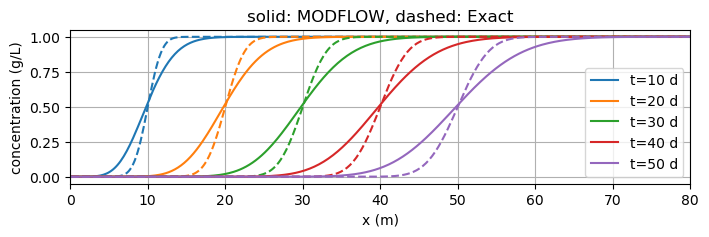

In [10]:
# plot concentration
plt.figure(figsize=(8, 2))
for i, t in enumerate(np.arange(10, 51, 10)):
    itime = np.abs(times - t).argmin() # find index of value in times closest to t
    plt.plot(xg, c[itime, 0], 'C' + str(i), label=f't={times[itime]:.0f} d')
    cex = c_exact(xg, t, vavg, alphaL, cs)
    plt.plot(xg, cex, 'C' + str(i), ls='--')
plt.xlabel('x (m)')
plt.ylabel('concentration (g/L)')
plt.xlim(0, 80)
plt.legend()
plt.title('solid: MODFLOW, dashed: Exact')
plt.grid()